# Домашняя работа 5. Линейная регрессия. (33 балла)

> Линейная регрессия - это не повод для затяжной депрессии.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.
4. Пришлите на почту ml-teachers ссылку на этот файл в вашем репозитории.
5. В теме письма указать `ML Homework #5: Name Surname`. Если тема будет неправильная, то задание не будет проверено.

**Дедлайн**: 27.11.2017 01:00 OMSK

    После дедлайна можно сдать, но вы получите штраф по баллам в рейтинге.

**Рассылка решений**: 30.11.2017 17:00 OMSK

    После рассылки задания совсем не имеют веса.

### Полезная литература

- [Первый конспект лекции про линейную регрессию из курса ФШЭ](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture02-linregr.pdf)
- [Второй конспект лекции про линейную регрессию из курса ФШЭ](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture03-linregr.pdf)
- [Теория из курса ODS](https://github.com/Yorko/mlcourse_open/blob/master/jupyter_notebooks/topic04_linear_models/topic4_linear_models_part1_mse_likelihood_bias_variance.ipynb)
- [Материалы из курса от МФТИ](https://www.coursera.org/specializations/machine-learning-data-analysis)
- [Статья про лин.рег. от ODS на habrahabr](https://habrahabr.ru/company/ods/blog/323890/)

## Данные

Возьмем датасет о стоимости домов: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. Там же читайте описание данных.

Целевой переменной будет `SalePrice`. То есть мы будем предсказывать стоимость жилья на основе его характеристик. Это задание будет не то чтобы про линейную регрессию, но про попытку построить модель для предсказания цен на дом. В принципе я бы мог еще добавить заданий на более тщательный отбор признаков, логарифмирование признаков у которых сильное смещение "скоса"(skew). Можно было бы анализировать и выпрямлять распределение целевой переменной. Можно было бы генерировать новые признаки из существующих, строить ансаибли моделей. Но тут мы ограничимся пока что.......

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('data/house_prices.csv.gz', index_col='Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
assert df.shape == (1460, 80)

In [4]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## 1.0 Анализ целевого признака (3 балла)

Удостоверимся, что раcпределение целевого признака "хорошее", без странных выбросов. В идеале мы хотим видеть нормальное распределени или достаточно похожее на него, без очень длинных "хвостов" выбросов.

_Почему требуется нормальность распределения: ищите объяснения линейной регресси через алгоритмы максимизации правдоподобия. В итоге, грубо говоря, суть сводится к тому, что с ростом объема выборки, оценка максимального правдоподобия лучше описывает нормальное распределение._

[Коэффициент эксцесса](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D1%8D%D0%BA%D1%81%D1%86%D0%B5%D1%81%D1%81%D0%B0) показывает степень остроты пика распределения случайной величины. Для нормального распределения он равен `0`. Если хвосты распределения «тяжелее», а пик более «приплюснутый», чем у нормального распределения, то коэффициент < 0. А если хвосты легкие, то больше 0. В нашем случае должно получиться околов `6.5`.

Задание: 
- Нарисуйте график распределения `SalePrice`, используйте аргумент `fit=scipy.stats.norm`, чтобы нарисовать предполагаемое нормальное распределение. Напечатайте значение коэффициент эксцесса `kurtosis` для этого признака.
- Нарисуйте график [scipy.stats.probplot](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.probplot.html) - он покажет нам реальные квантили выборки и теоретические. По нему можно видеть, на сколько много выьросов и на сколько выборка предсказуема.
- Что вы можете сказать по поводу выборки основываясь на `probplot`.  [wiki](https://en.wikipedia.org/wiki/Normal_probability_plot)

In [5]:
from scipy import stats

6.509812011089439


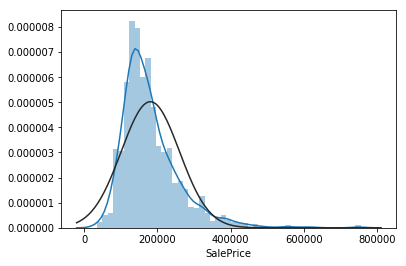

In [6]:
sns.distplot(df['SalePrice'], fit=stats.norm)
print(stats.kurtosis(df['SalePrice']))

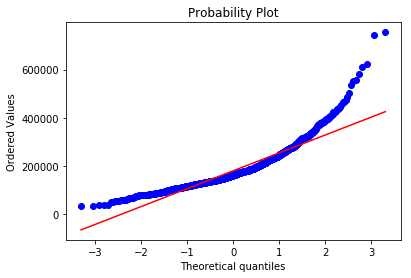

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(df['SalePrice'], plot=ax)
plt.show()

График нормальной вероятности демонстрирует отклонения квантилей от нормального распределения. Как мы видим, на данном графике наибольшие отклонения происходят в начале и конце, плюс присутствует как минимум два выброса при высоких ценах. Стоит также отметить, что при повышении цены отклонения становятся более значимыми. Это может говорить о том, что есть дома, которые стоят сильно дороже среднего.

## 1.1 Анализ некоторых зависимостей (3 балла)

У нас очень много разных признаков. Любопытно построить разные графики. Позаботьтесь о красоте и наглядности графиков, сделайте так, чтобы они были большие и их можно было прочесть. Даже подписи на графиках должны быть читаемые!!

Задания: Постройте графики, отражающие зависимости этих признаков:
- дата постройки дома и его стоимости
- "качество дома и материалов" и его стоимости
- площадь дома и стоимость

Hints: Вспомните про boxplot, jointplot, lmplot...

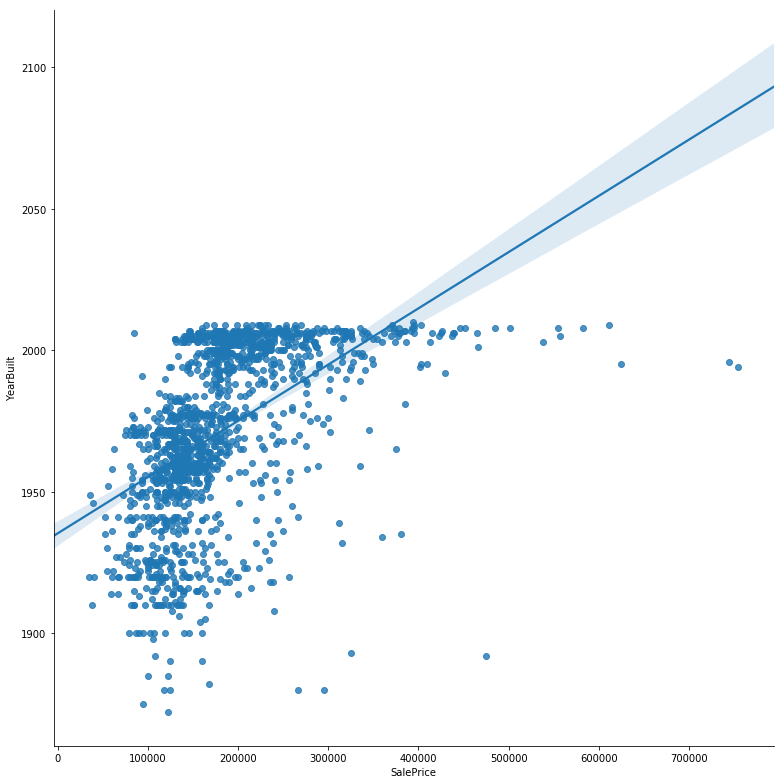

In [8]:
sns.lmplot(x='SalePrice', y='YearBuilt', data=df, size=11)

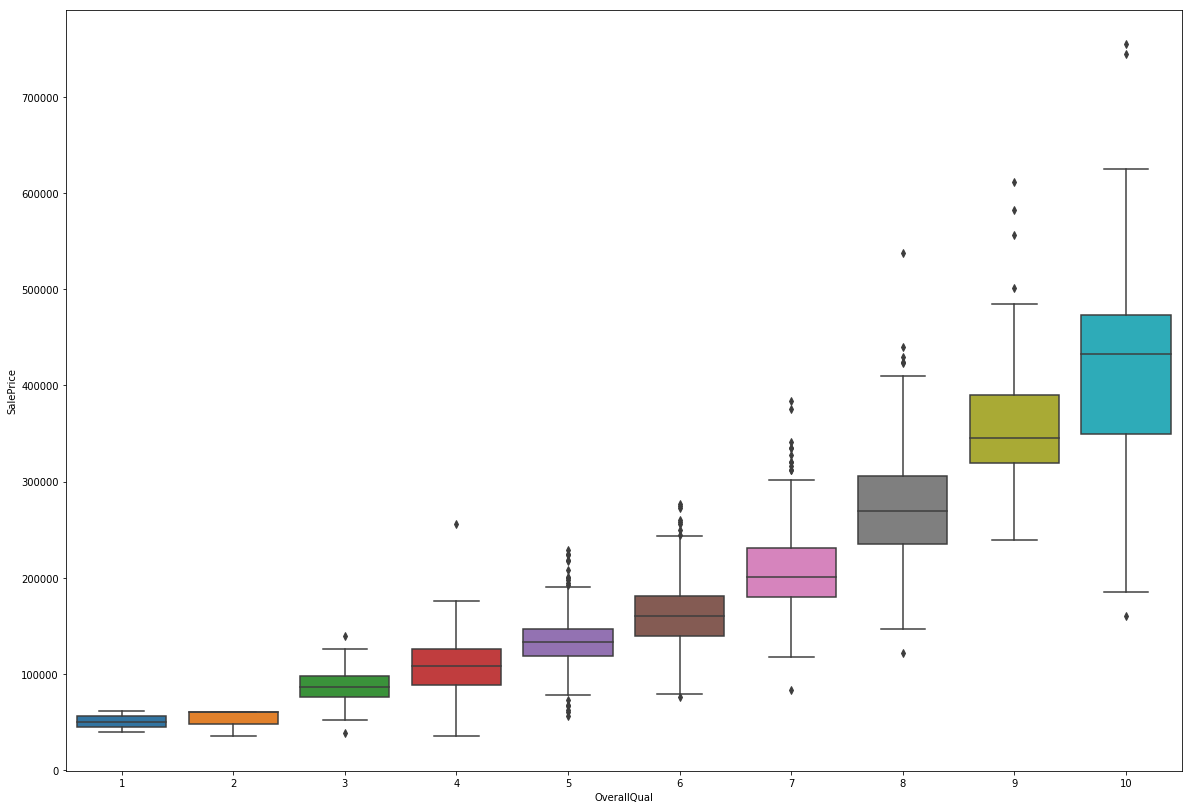

In [9]:
fig, ax = plt.subplots(figsize=(20, 14))
sns.boxplot(x=df['OverallQual'], y=df['SalePrice'], ax=ax)

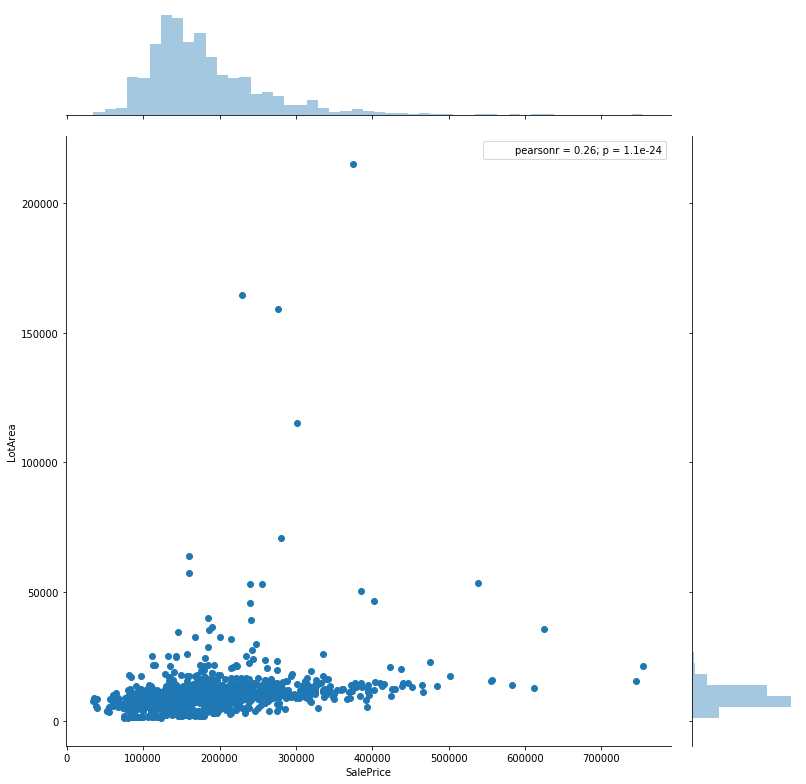

In [10]:
sns.jointplot(x='SalePrice', y='LotArea', data=df, size=11)

## 1.2 Heatmap (3 балла)

Судя по предыдущим графикам, есть некоторые линейные зависимости. Но строить по графику на каждый признак из 80 штук немного долго и не наглядно. Постройте красивый график корреляции всех признаков. Используйте цвета `RdYlGn`, так будет нагляднее. Не забудьте применить маску, чтобы убрать дублирующую половину матрицы.

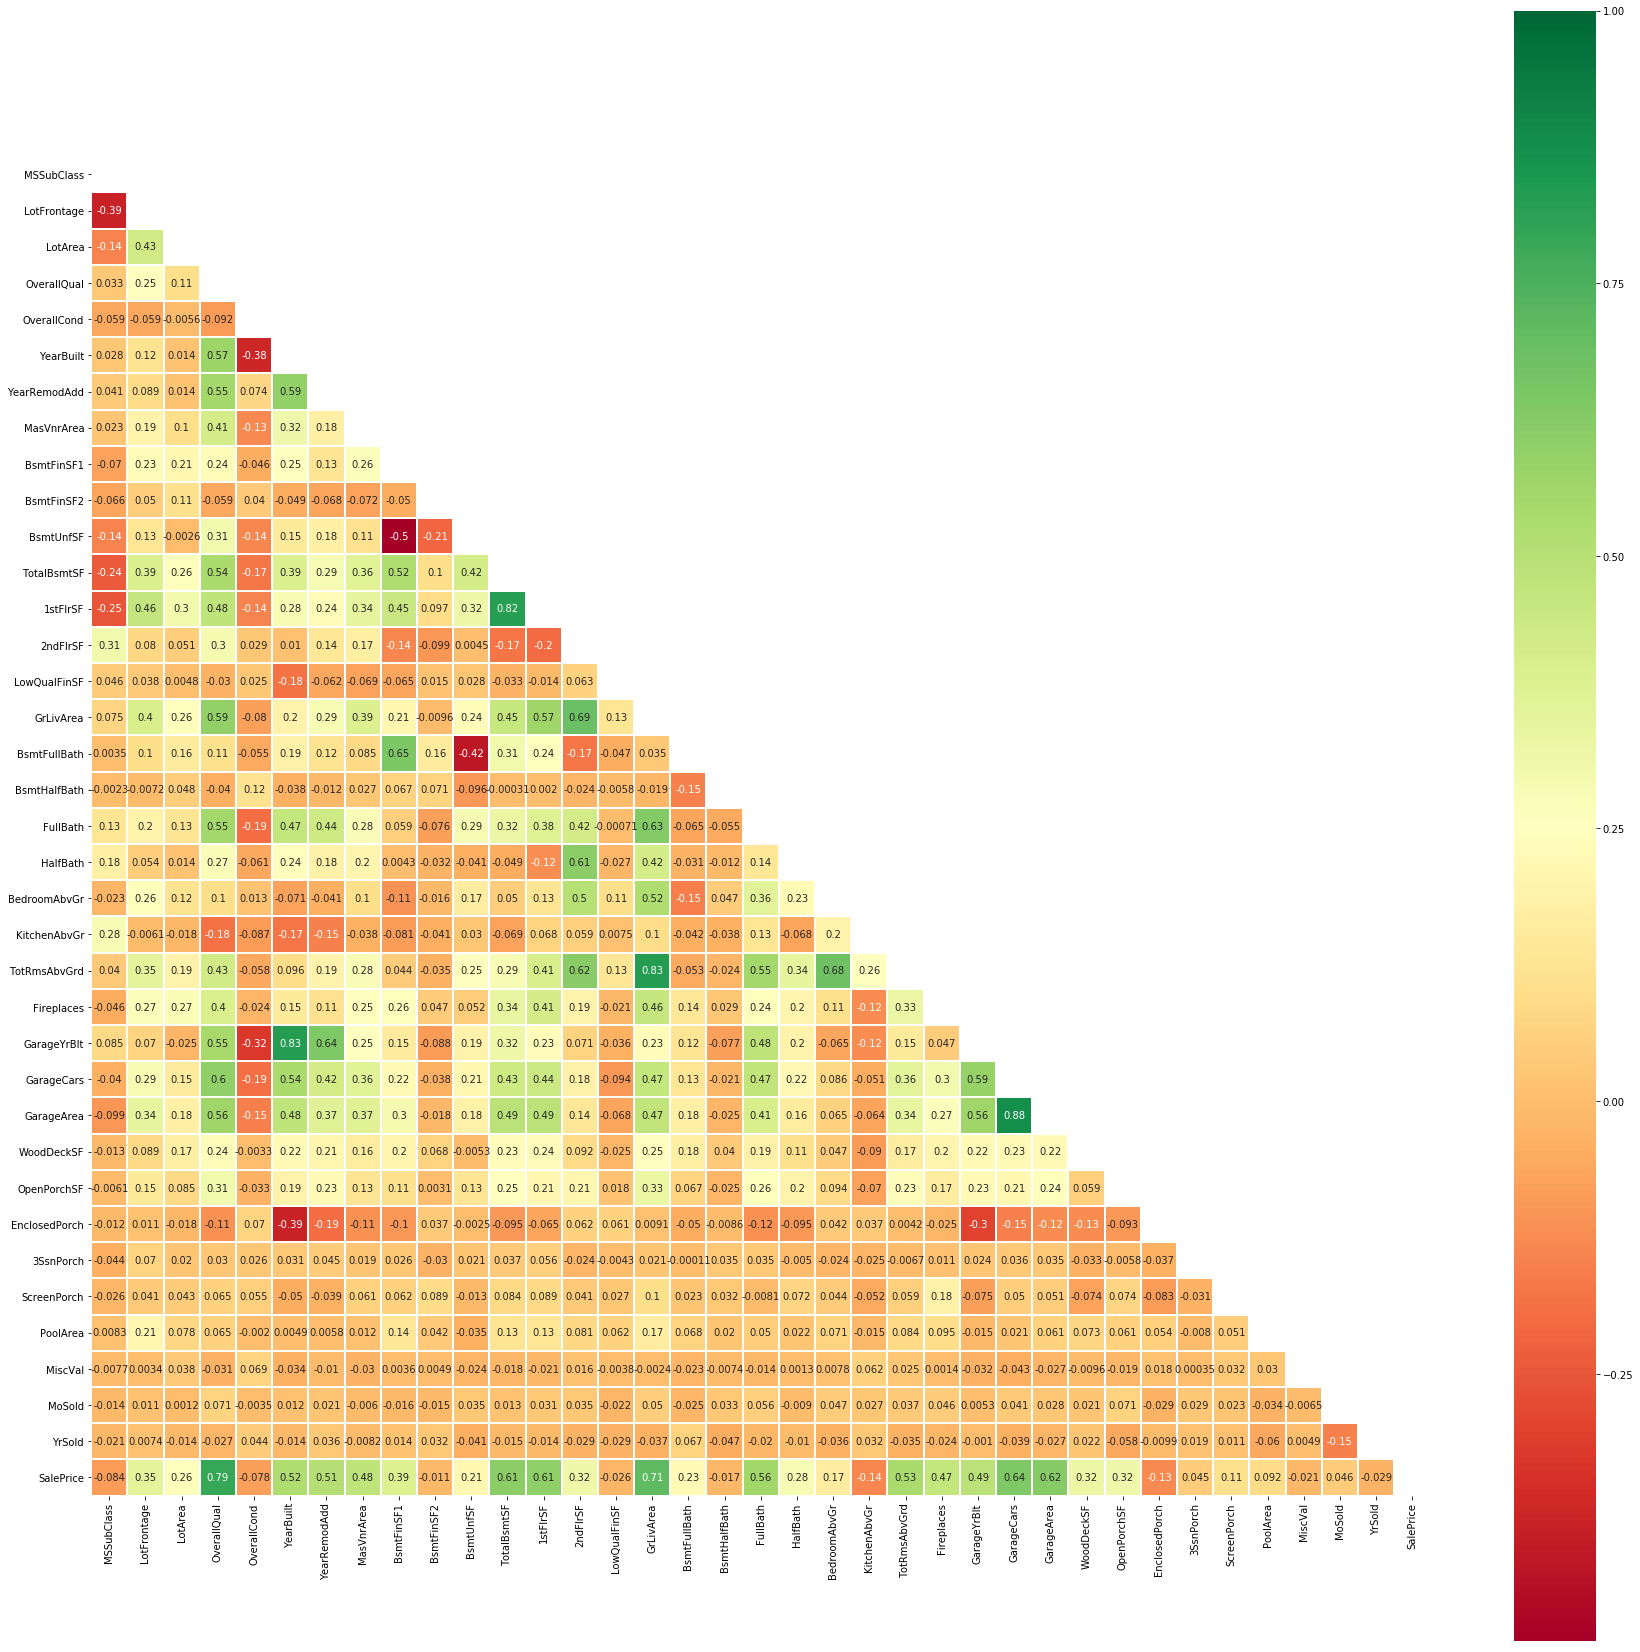

In [11]:
from matplotlib.colors import ListedColormap

corr = df.corr()
fig, ax = plt.subplots(figsize=(30, 30))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap="RdYlGn", square=True, linewidths=1, annot=True, ax=ax, mask=mask)

Большая матрица 38x38 ячеек. И мы видим, там есть сильно коррелируемые объекты с нашей целевой переменной. 

- Нарисуйте крупно heatmap этих сильно коррелируемых объектов( больше 0.5 по абсолютному значению) и сделайте так, чтобы в каждой ячейке было значение корреляции. 
- Выведите список этих сильно коррелируемых признаков.

Запомним эти признаки!

In [159]:
#corr = df.corr()
#fig, ax = plt.subplots(figsize=(30, 30))
#mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True
#sns.heatmap(corr, cmap="RdYlGn", square=True, linewidths=1, annot=True, ax=ax, mask=mask)

## 1.3 Пропущеные данные (3 балла)

Задание:
 - Посчитайте общее количество пропущенных данных по каждому признаку
 - посчитайте долю пропущенных данных выборки
 - удалите из выборки признаки, доля пропущенных которых больще 10%
 - пропущенные категориальные заполните словом 'unknown' (у них dtype object)
 - пропущенные числовые заполните средним (у них dtype float)

Hinst: https://stackoverflow.com/a/38134049/3205200

In [14]:
for column in df:
    nans = df[column].isnull().sum()
    print('{:.2f}'.format(nans/1460 * 100) + "%")

0.00%
0.00%
17.74%
0.00%
0.00%
93.77%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.55%
0.55%
0.00%
0.00%
0.00%
2.53%
2.53%
2.60%
2.53%
0.00%
2.60%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.07%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
47.26%
5.55%
5.55%
5.55%
0.00%
0.00%
5.55%
5.55%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%
99.52%
80.75%
96.30%
0.00%
0.00%
0.00%
0.00%
0.00%
0.00%


In [15]:
#не самый оптимальный вариант - оно строго фиксировано на нынешнем количестве строк
df2 = df.copy()
for column in df2:
    nans = df2[column].isnull().sum()
    if (nans/1460 > .1):
        df2.drop(column, axis=1, inplace=True)
    else:
        if (df2[column].dtype == np.float64):
            df2[column] = df2[column].fillna(value=df[column].mean())
        else:
            df2[column] = df2[column].fillna(value="unknown")

## 1.4 Категориальные переменные (1 балл)

На сколько вы помните, линейная регрессия не умеет обрабатывать категориальные признаки, так как ей нужны ЧИСЛА. Но не беда, в pandas есть встроенная функция [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html).

Задание:
- сконвертируйте все категориальные признаки(dtype=object) в вектора числовых с помощью get_dummies
- напечатайте сколько у вас теперь признаков
- Положите в переменную X все данные из датасета, кроме целевой переменной. Положите в переменную y только целевую переменную.

In [18]:
df2_dummies = pd.get_dummies(df2)
df2_dummies.columns

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=281)

In [20]:
X = df2_dummies.drop('SalePrice', axis=1)
y = df2['SalePrice']

## 1.5 Переобучение (3 балла)

Обучим обычную модель без регуляризации [sklearn.linear_model.LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

- Выведите все коэффициенты для каждого признака, отсортировав по возрастанию по модулю значения коэффициента. Используйте print и for, иначе jupyter схлопнет вывод numpy массива. Можете округлить коэффициенты до 2 знаков после запятой.
- Выведите **среднее** ошибки предсказания на 5 фолдах (cv=5) для этой линейной регрессии с помощью функции [sklearn.model_selection.cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Укажите `scoring='neg_mean_squared_error'`, чтобы считалась [MSE](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error)

In [22]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)
for coef, col in sorted(zip(lr.coef_, df2_dummies.columns), key=lambda x: np.abs(x[0])):
    print("{:.2f} \t {}".format(coef, col))

0.11 	 MiscVal
0.77 	 LotArea
-1.91 	 BsmtUnfSF
3.46 	 OpenPorchSF
4.68 	 EnclosedPorch
7.14 	 BsmtFinSF2
13.35 	 WoodDeckSF
16.02 	 1stFlrSF
16.86 	 BsmtFinSF1
18.02 	 GarageArea
18.75 	 MasVnrArea
-20.29 	 LowQualFinSF
22.09 	 TotalBsmtSF
-27.08 	 GarageYrBlt
28.47 	 ScreenPorch
31.09 	 GrLivArea
-31.51 	 MSSubClass
32.57 	 3SsnPorch
35.36 	 2ndFlrSF
-84.57 	 Exterior2nd_Wd Sdng
85.15 	 PoolArea
97.23 	 YearRemodAdd
129.85 	 MasVnrType_BrkCmn
146.39 	 CentralAir_N
-146.39 	 HeatingQC_TA
-164.61 	 GarageType_unknown
-244.53 	 GarageFinish_RFn
-277.18 	 Functional_Min2
320.70 	 YearBuilt
-374.27 	 GarageType_Basment
-403.94 	 YrSold
424.01 	 Exterior2nd_ImStucc
-436.53 	 MoSold
-457.17 	 Heating_GasW
-509.16 	 LotShape_Reg
509.94 	 Functional_Maj1
-527.87 	 BsmtFinType1_ALQ
-538.04 	 Exterior2nd_AsphShn
541.84 	 BsmtFinType1_Rec
-618.67 	 BsmtHalfBath
-644.12 	 ExterCond_Ex
-649.60 	 Exterior1st_CBlock
706.89 	 GarageCond_unknown
740.84 	 GarageType_2Types
761.31 	 BsmtFullBath
771.94 

In [23]:
from sklearn.model_selection import cross_val_score

cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=5)

array([ -8.25283878e+08,  -1.17623540e+09,  -1.41440984e+09,
        -5.70497624e+08,  -2.18007954e+09])

К счастью в этот раз коэффициенты при признаках не улетели в космос, но всё равно достигли очень больших значений. Например `RoofStyle_Shed` получился в моем случае около `-514961`. А у некоторых признаков коэффициент уже равен 0, хотя не была применена регуляризация.

## 1.6 Ridge и Lasso (4 балла)

- Обучите Lasso и Ridge для разных значений регуляризации alpha
- нарисуйте график значений коэффициентов модели для каждого признака, как мы делали на практике. По оси X будет значение alpha, по Y - значение коэффициента. на графике будет "радуга" из линий разных цветов(линий столько, сколько признаков).
- Нарисуйте гистограмму, в которой по оси Y будет количество коэффициентов, равных 0 (<0.0001) для Loss регресиии, а по оси X - значение коэффициента альфа.

alpha взять от 1 до 500 с каким-нибудь шагом. Но не переборщите, а то долго будете ждать.

In [35]:
from sklearn.linear_model import Lasso, Ridge

alphas = np.arange(1, 500, 5)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1]))

i = 0
for alpha in alphas:
    lasso = Lasso(alpha = alpha, random_state=42)
    lasso.fit(X, y)
    coefs_lasso[i, :] = lasso.coef_
    
    i += 1

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


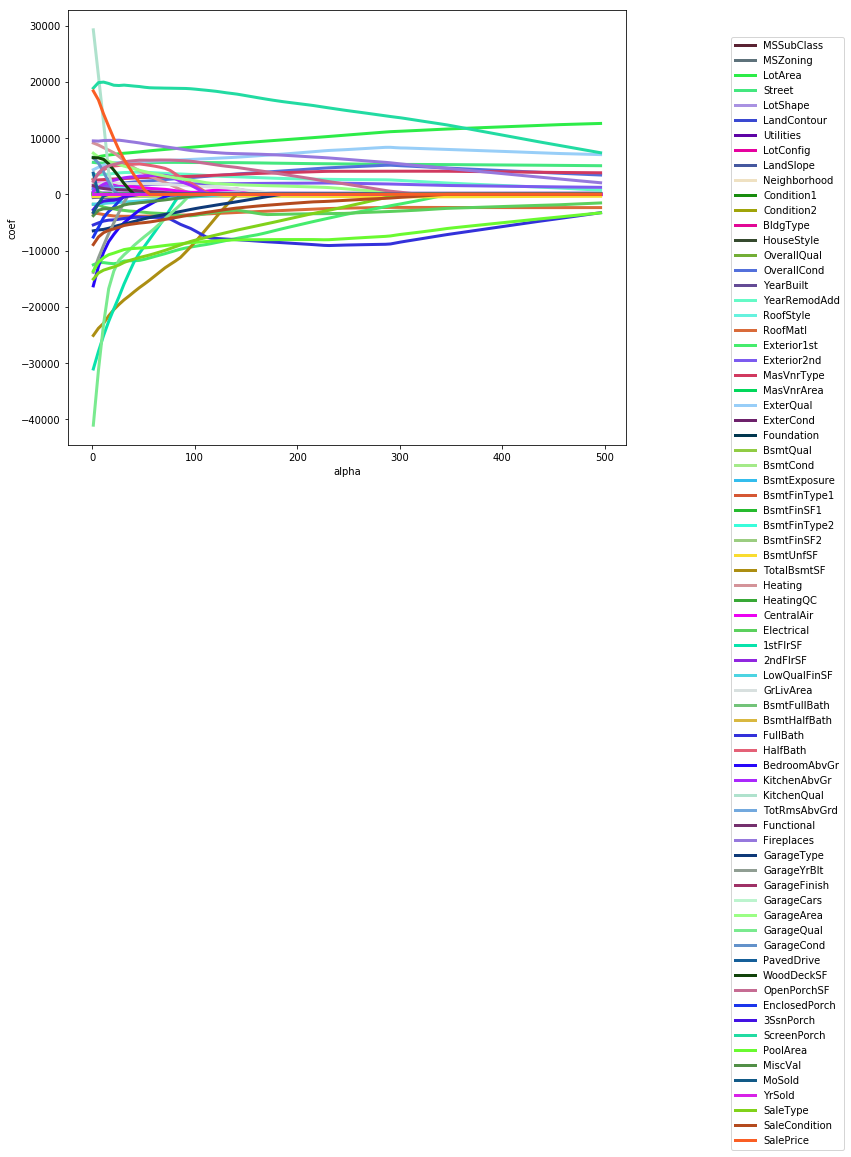

In [37]:
plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_lasso.T, df2.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3), linewidth=3)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("coef")

In [38]:
coefs_rigde = np.zeros((alphas.shape[0], X.shape[1]))

i = 0
for alpha in alphas:
    rigde = Ridge(alpha = alpha, random_state=42)
    rigde.fit(X, y)
    coefs_rigde[i, :] = rigde.coef_
    
    i += 1

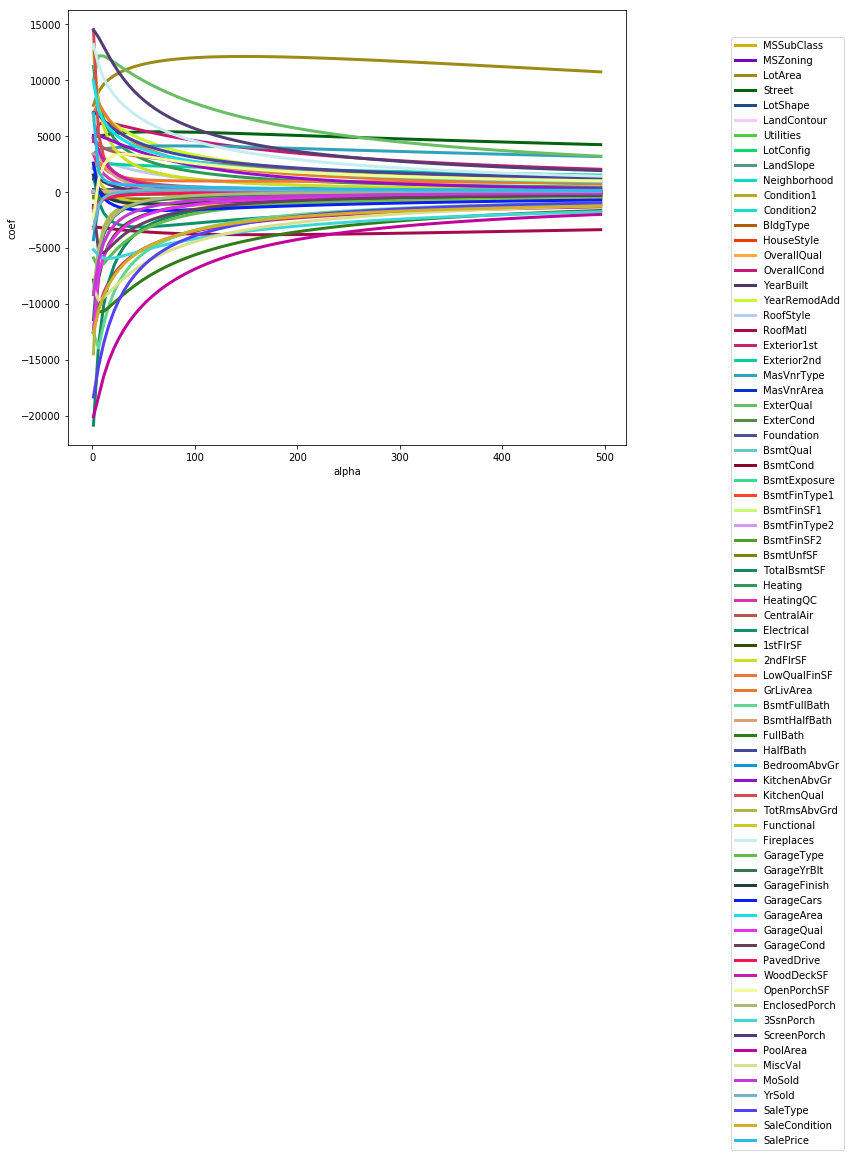

In [39]:
plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_rigde.T, df2.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3), linewidth=3)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("coef")

## 1.7 Поиск оптимального alpha (6 баллов)

- С помощью метода LassoCV найдите оптимальное значение alpha и напечатайте его, используя разбиение на 5 фолда в кроссвалидации (`cv=5`).
- Нарисуйте график зависимости MSE от alpha (`mse_path_`).
- Нарисуйте длинную гистограмму магнитуда признаков, как в классе, на которой будет показано значение коэффициента для каждого признака. Графк должен быть остортирован по величине коэффициентов. Признаки с нулевыми коэффициентами должны быть удалены.
- Сколько в итоге ненулевых признаков осталось?
- Выведите **среднее** ошибки предсказания на 5 фолдах (cv=5) для этой линейной регрессии с помощью функции [sklearn.model_selection.cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Укажите `scoring='neg_mean_squared_error'`, чтобы считалась [MSE](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error). Качество должно быть лучше, чем у простой линейной регрессии.

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


125.75


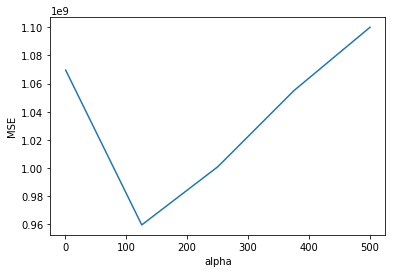

In [45]:
from sklearn.linear_model import LassoCV

alphas = np.linspace(1,500,5)
lasso_cv = LassoCV(alphas=alphas, random_state=42)
lasso_cv.fit(X, y)

mean_mse = np.mean(lasso_cv.mse_path_, axis = 1)
plt.plot(lasso_cv.alphas_, mean_mse)
plt.xlabel('alpha')
plt.ylabel('MSE')
print(lasso_cv.alpha_)

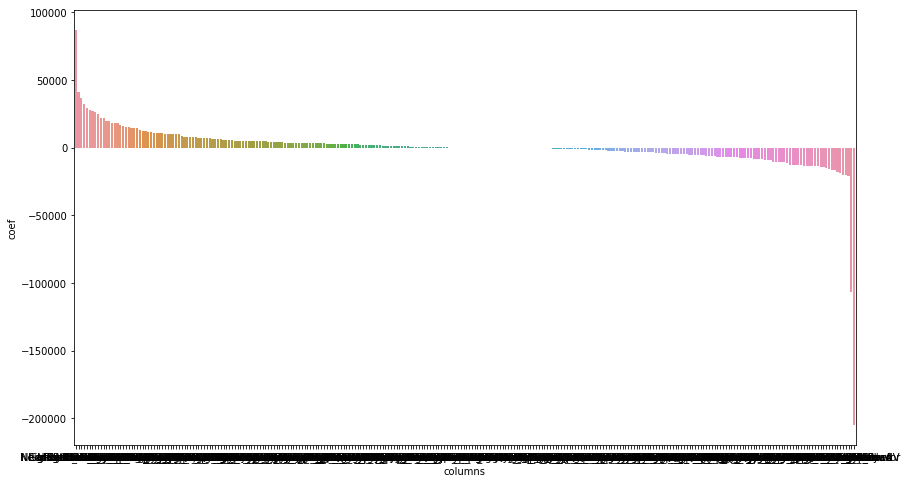

In [52]:
plt.figure(figsize=(14,8))
data = pd.DataFrame(list(zip(ridge.coef_, df2_dummies.columns)), 
                              columns=["coef", "columns"]).sort_values(by='coef', ascending=False)

sns.barplot(x='columns', y='coef', 
            data=data[data.coef.notnull()])

In [44]:
cross_val_score(lasso_cv, X, y, cv=5)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/pyth

array([ 0.91004739,  0.83929951,  0.87862424,  0.89038357,  0.71640828])

## 1.8 Предсказание на отложенной выборке (3 балла)

- Используя [sklearn.model_selection.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) разбейте датасет на 2 части - тренировочную и тестовую в соотношении 0.33. Не забудьте перемешать!
- Напечатайте размерность X_train и X_test

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape)
print(X_test.shape)

(978, 280)
(482, 280)


Теперь, возьмите вашу самую мощную модель(не тренированную!). Запустите её тренировку по тренировочной выборке X_train, y_train с помощью функции `fit`. Постройте предсказания с помощью функции `predict`.

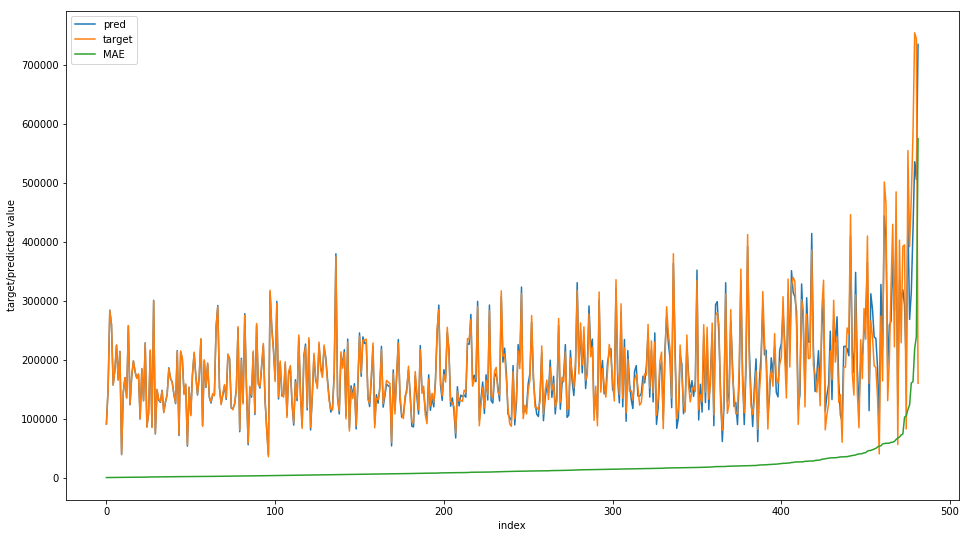

In [60]:
reg = Lasso(lasso_cv.alpha_)
reg.fit(X_train, y_train)

pred = reg.predict(X_test)

prediction = pd.DataFrame(np.vstack((pred, y_test)).T, columns=["pred", "target"])
prediction['MSE'] = np.power(prediction['pred'] - prediction['target'], 2)
prediction['MAE'] = np.abs(prediction['pred'] - prediction['target'])
prediction.sort_values(by='MAE', inplace=True)

plt.figure(figsize=(16,9))

plt.plot(range(0, prediction.shape[0]), prediction['pred'])
plt.plot(range(0, prediction.shape[0]), prediction['target'])
plt.plot(range(0, prediction.shape[0]), prediction['MAE'])
plt.legend(["pred", "target", "MAE"])

plt.xlabel("index")
plt.ylabel("target/predicted value")

Визуализируйте scatter plot предсказанных значений и настоящих (`y_test`). У вас должен получиться график, точки которого расположены приблизительно вдоль некоторой прямой с разбросом. Идеальный предсказатель будет выглядить как набор точек вдоль прямой без разброса.

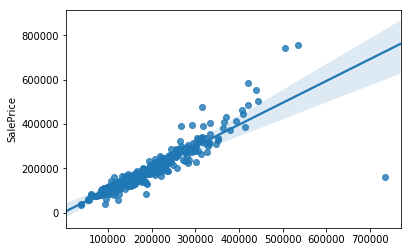

In [61]:
sns.regplot(x=pred, y=y_test)

## 1.9 Ограниченная версия ( 4 балла)

Помните в самом начале мы оставили очень мало признаков по данным из heatmap. Настало время проверить как он себя покажет! К счастью они все сразу числовые, а не категориальные. Переиспользуйте тот дадасет, где вы уже поборолись с пропусками.
Снова выделите отдельно X и y и запустите кроссвалидацию c 5 фолдами по Lasso с `alpha=1`.

Можете посмотреть еще много разных примеров обработки этого датасета тут: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels

А суть всего этого такова, что в итоге надо кучу времени потратить на подготовку признаков. Смотреть на кучу графиков а потом стакать модели.